In [1]:
from typing import Any
import warnings

from rl_qoc.qua.gate_macros.flux_tunable_gate_macros import CZMacro

from qm import QuantumMachinesManager, SimulationConfig
from qm.qua import *
from qm_saas import QoPVersion, QmSaas
from rl_qoc.qua.gate_macros import MeasureMacro, ResetMacro, VirtualZMacro, CZMacro, DelayMacro
from qiskit_qm_provider import FluxTunableTransmonBackend, ParameterTable, Parameter as QuaParameter
from quam.components.macro import PulseMacro
from quam.core.operation.operations_registry import OperationsRegistry
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector, QuantumRegister
import qiskit.pulse as qp
from qiskit import transpile
import matplotlib.pyplot as plt
from qm import generate_qua_script
import numpy as np
from quam_builder.architecture.superconducting.qpu.flux_tunable_quam import FluxTunableQuam as QuAM
import warnings
import logging

# Silence DeprecationWarnings from qiskit.pulse
warnings.filterwarnings("ignore", category=DeprecationWarning, module=r"qiskit\.pulse")
# Filter all DeprecationWarnings
logging.getLogger("qiskit").setLevel(logging.ERROR)

machine = QuAM.load(
    f"/Users/arthurostrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control/pulse_level/qua/quam_state"
)
backend = FluxTunableTransmonBackend(machine)
print(backend.target)


2025-05-15 15:02:32,919 - qm - INFO     - Starting session: b959e374-0919-44e2-8b05-52d30c9eb198
2025-05-15 15:02:32 INFO Starting session: b959e374-0919-44e2-8b05-52d30c9eb198
Target: Transmon based QuAM
Number of qubits: 5
Instructions:
	x
		(0,)
		(1,)
		(2,)
		(3,)
		(4,)
	rz
		(0,)
		(1,)
		(2,)
		(3,)
		(4,)
	sx
		(0,)
		(1,)
		(2,)
		(3,)
		(4,)
	measure
		(0,)
		(1,)
		(2,)
		(3,)
		(4,)
	reset
		(0,)
		(1,)
		(2,)
		(3,)
		(4,)
	delay
		(0,)
		(1,)
		(2,)
		(3,)
		(4,)
	cz
		(0, 1)
		(1, 2)
		(2, 3)
		(3, 4)
	if_else
	while_loop
	for_loop
	switch_case



In [11]:
import os
import json
from iqcc_cloud_client import IQCC_Cloud

# Set your quantum computer backend
quantum_computer_backend = "arbel"  # for example qc_qwfix
qc = IQCC_Cloud(quantum_computer_backend=quantum_computer_backend)

# Get the latest state and wiring files
latest_wiring = qc.state.get_latest("wiring")
latest_state = qc.state.get_latest("state")

# Get the state folder path from environment variable
quam_state_folder_path = os.environ['QUAM_STATE_PATH']

# Save the files
with open(os.path.join(quam_state_folder_path, "wiring.json"), "w") as f:
    json.dump(latest_wiring.data, f, indent=4)

with open(os.path.join(quam_state_folder_path, "state.json"), "w") as f:
    json.dump(latest_state.data, f, indent=4)

In [ ]:
qc.qiskit_backend()

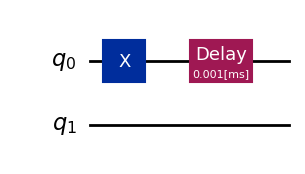

In [5]:
from qiskit.circuit import QuantumCircuit

qc = QuantumCircuit(2)
qc.x(0)
qc.delay(0.001, 0, "ms")
qc.draw("mpl")

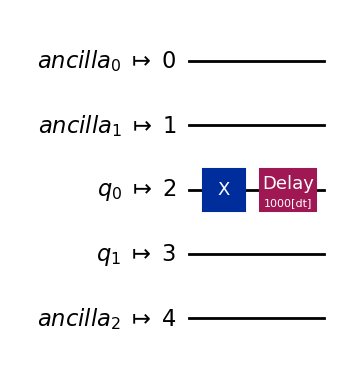

In [3]:
from qiskit import transpile

qc = transpile(qc, backend=backend, initial_layout=[2,3],
               optimization_level=0)
qc.draw("mpl")

In [4]:
qc.data

[CircuitInstruction(operation=Instruction(name='x', num_qubits=1, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(5, 'q'), 2),), clbits=()), CircuitInstruction(operation=Delay(duration=1000[unit=dt]), qubits=(Qubit(QuantumRegister(5, 'q'), 2),), clbits=())]

In [5]:
from qiskit.circuit import QuantumCircuit, QuantumRegister

In [12]:
from rl_qoc.rewards.real_time_utils import get_real_time_reward_circuit
from rl_qoc import (
    QEnvConfig,
    QiskitConfig,
    ExecutionConfig,
    BenchmarkConfig,
    GateTargetConfig,
)
from rl_qoc.qua import QMConfig, QMEnvironment

from gymnasium.spaces import Box


def apply_parameters(qc: QuantumCircuit, params: ParameterVector, qreg: QuantumRegister):
    idx_0 = qreg.index(qreg[0])

    if len(qreg) > 1:
        idx_1 = qreg.index(qreg[1])
        with qp.build(backend) as sched:
            qp.play(qp.Constant(duration=120, amp=0.1), backend.flux_channel(idx_0))
            qp.play(
                qp.Constant(duration=120, amp=params[0]),
                backend.control_channel((idx_0, idx_1))[0],
            )
        qc.add_calibration(
            "rzz",
            [0, 1],
            sched,
            params.params if isinstance(params, ParameterVector) else params,
        )
        qc.rzz(params[0], qreg[0], qreg[1])
    else:
        with qp.build(backend) as sched:
            qp.play(
                qp.Drag(duration=120, amp=params[0], sigma=40, beta=0.2),
                backend.drive_channel(idx_0),
            )
        qc.add_calibration(
            "rx",
            [
                0,
            ],
            sched,
            params.params if isinstance(params, ParameterVector) else params,
        )
        qc.rx(params[0], qreg[0])
    with qp.build(backend, name="x_custom") as sched:
        qp.play(
            qp.Drag(duration=120, amp=0.3, sigma=40, beta=0.2),
            backend.drive_channel(idx_0),
        )
    qc.add_calibration(
        "x",
        [
            0,
        ],
        sched,
    )
    qc.add_calibration(
        "x",
        [
            1,
        ],
        sched,
    )


physical_qubits = [0]
gate = "cz" if len(physical_qubits) > 1 else "x"
n_reps = [2, 5]
config = QEnvConfig(
    target=GateTargetConfig(physical_qubits, gate),
    backend_config=QiskitConfig(
        backend=backend,
        parametrized_circuit=apply_parameters,
    ),
    execution_config=ExecutionConfig(
        batch_size=1,
        n_shots=100,
        n_reps=n_reps,
        control_flow_enabled=True,
    ),
    reward="state",
    action_space=Box(low=-1, high=1, shape=(1,), dtype=np.float32),
)

qm_config_args = {
    "input_type": "IO1",
    "num_updates": 500,
    "init_macro": backend.machine.apply_all_flux_to_joint_idle,
}
config.backend_config = QMConfig(**config.backend_config.as_dict(), **qm_config_args)

q_env = QMEnvironment(config)

/var/folders/5w/ygx15jq94z5dzxwkmbbj8zfm0000gn/T/ipykernel_12869/300237815.py:33: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with qp.build(backend) as sched:
/var/folders/5w/ygx15jq94z5dzxwkmbbj8zfm0000gn/T/ipykernel_12869/300237815.py:34: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  qp.play(
/var/folders/5w/ygx15jq94z5dzxwkmbbj8zfm0000gn/T/ipykernel_12869/300237815.py:38: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.add_calibration()`` is deprecated as of Qiskit 1.3. I

In [3]:
q_env.rl_qoc_training_qua_prog()

In [13]:
from qm import generate_qua_script

print(
    generate_qua_script(
        backend.quantum_circuit_to_qua(q_env.real_time_circuit).result_program.dsl_program
    )
)


# Single QUA script generated at 2025-05-14 15:09:20.266319
# QUA library version: 1.2.2rc2+dgx2


from qm import CompilerOptionArguments
from qm.qua import *

with program() as prog:
    input_stream_a_0_0 = declare_input_stream(fixed, 'a_0_0', value=0.0)
    input_stream_observable_0 = declare_input_stream(int, 'observable_0', value=0)
    input_stream_n_reps = declare_input_stream(int, 'n_reps', value=0)
    input_stream_input_state_0 = declare_input_stream(int, 'input_state_0', value=0)
    a1 = declare(bool, value=[False])
    v1 = declare(int, value=0)
    v2 = declare(int, value=0)
    v3 = declare(int, value=0)
    v4 = declare(fixed, value=0.0)
    v5 = declare(bool, )
    v6 = declare(fixed, )
    v7 = declare(fixed, )
    v8 = declare(fixed, )
    v9 = declare(fixed, )
    v10 = declare(bool, )
    v11 = declare(int, value=1)
    advance_input_stream(input_stream_a_0_0)
    advance_input_stream(input_stream_observable_0)
    advance_input_stream(input_stream_n_reps)
    adv

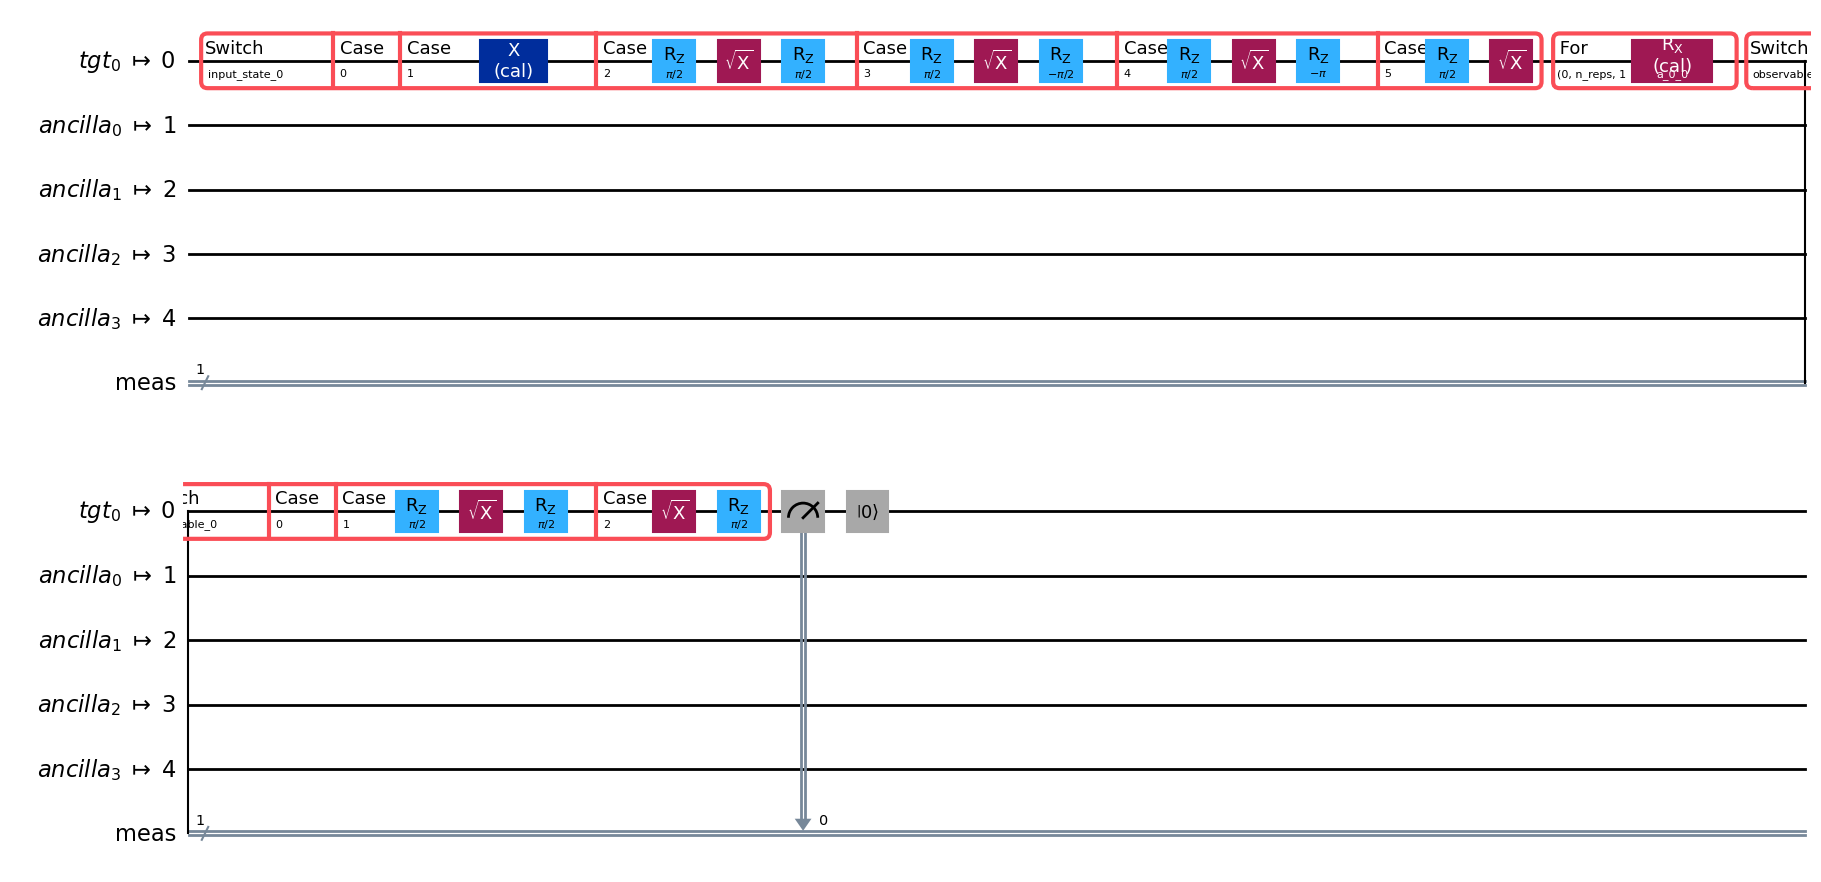

In [5]:
q_env.real_time_circuit.draw("mpl")

In [6]:
print(backend.target)

Target: Transmon based QuAM
Number of qubits: 5
Instructions:
	x
		(0,)
		(1,)
		(2,)
		(3,)
		(4,)
	rz
		(0,)
		(1,)
		(2,)
		(3,)
		(4,)
	sx
		(0,)
		(1,)
		(2,)
		(3,)
		(4,)
	measure
		(0,)
		(1,)
		(2,)
		(3,)
		(4,)
	reset
		(0,)
		(1,)
		(2,)
		(3,)
		(4,)
	delay
		(0,)
		(1,)
		(2,)
		(3,)
		(4,)
	cz
		(0, 1)
		(1, 2)
		(2, 3)
		(3, 4)
	if_else
	while_loop
	for_loop
	switch_case



In [4]:
q_env.real_time_circuit.calibrations

/var/folders/5w/ygx15jq94z5dzxwkmbbj8zfm0000gn/T/ipykernel_96370/620505994.py:1: DeprecationWarning: The property ``qiskit.circuit.quantumcircuit.QuantumCircuit.calibrations`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics. Note that once removed, ``qiskit.circuit.quantumcircuit.QuantumCircuit.calibrations`` will have no alternative in Qiskit.
  q_env.real_time_circuit.calibrations


{'rx': {((0,),
   (Parameter(a_0_0),)): ScheduleBlock(Play(Drag(duration=120, sigma=40, beta=0.2, amp=a_0_0, angle=0.0, name='block0_0'), DriveChannel(0)), name="block0", transform=AlignLeft())},
 'x': {((0,),
   ()): ScheduleBlock(Play(Drag(duration=120, sigma=40, beta=0.2, amp=0.3, angle=0.0, name='x_custom_015393985360'), DriveChannel(0)), name="x_custom", transform=AlignLeft()),
  ((1,),
   ()): ScheduleBlock(Play(Drag(duration=120, sigma=40, beta=0.2, amp=0.3, angle=0.0, name='x_custom_015393985360'), DriveChannel(0)), name="x_custom", transform=AlignLeft())}}

In [7]:
from qm import generate_qua_script

prog = q_env.rl_qoc_training_qua_prog()
print(generate_qua_script(prog))


# Single QUA script generated at 2025-05-13 19:48:53.510595
# QUA library version: 1.2.2rc2+dgx2


from qm import CompilerOptionArguments
from qm.qua import *

with program() as prog:
    v1 = declare(fixed, value=0.0)
    v2 = declare(int, value=0)
    v3 = declare(int, value=0)
    a1 = declare(fixed, value=[0.0])
    v4 = declare(int, )
    a2 = declare(fixed, value=[1.0])
    v5 = declare(int, )
    a3 = declare(int, value=[0, 0])
    v6 = declare(int, )
    v7 = declare(int, value=2)
    v8 = declare(int, value=0)
    v9 = declare(int, )
    v10 = declare(int, value=0)
    v11 = declare(int, value=100)
    v12 = declare(int, )
    v13 = declare(int, )
    v14 = declare(int, )
    v15 = declare(int, )
    a4 = declare(fixed, value=[-1.0])
    a5 = declare(fixed, value=[1.0])
    v16 = declare(int, )
    a6 = declare(fixed, value=[1.0, 0.9999247018391445, 0.9996988186962042, 0.9993223845883495, 0.9987954562051724, 0.9981181129001492, 0.9972904566786902, 0.996312612182778, 0.9951847

In [7]:
from qiskit_qm_provider import QMInstructionProperties
from qiskit.circuit import Gate

x_test = Gate("x_test", 1, [])


def x_test_macro():
    machine.active_qubits[0].apply("x")


instruction_prop = QMInstructionProperties(qua_pulse_macro=x_test_macro)

In [8]:
backend.target.add_instruction(x_test, {(0,): instruction_prop})

In [19]:
from qiskit_qm_provider import ParameterPool

ParameterPool.get_all()[6].get_parameter(0)

Parameter(input_state_1[int])

In [ ]:
id(ParameterPool.get_all()[6].get_parameter(0))

In [ ]:
q_env.circuit.draw("mpl")

In [ ]:
q_env.real_time_circuit.metadata["qua"]["input_state_vars"].get_parameter(0).tables

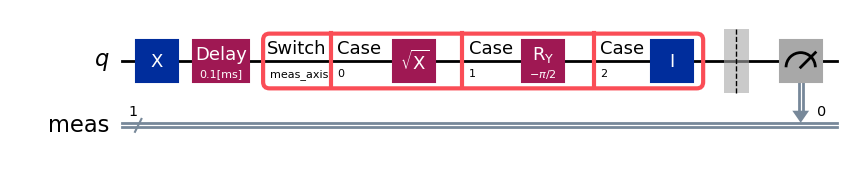

In [2]:
from qiskit.circuit.classical.types import Uint, Bool
from qiskit.circuit.classical import expr

cs_circuit = QuantumCircuit(1)
meas_axis = cs_circuit.add_input("meas_axis", Uint(3))
meas_axis2 = cs_circuit.add_input("meas_axis2", Bool())
var1 = cs_circuit.store(meas_axis2, expr.logic_not(expr.cast(meas_axis, Bool())))
cs_circuit.x(0)
cs_circuit.delay(0.1, 0, "ms")
with cs_circuit.switch(meas_axis) as case:
    with case(0):
        cs_circuit.sx(0)
    with case(1):
        cs_circuit.ry(-np.pi / 2, 0)
    with case(2):
        cs_circuit.id(0)

cs_circuit.measure_all()
cs_circuit.draw("mpl")

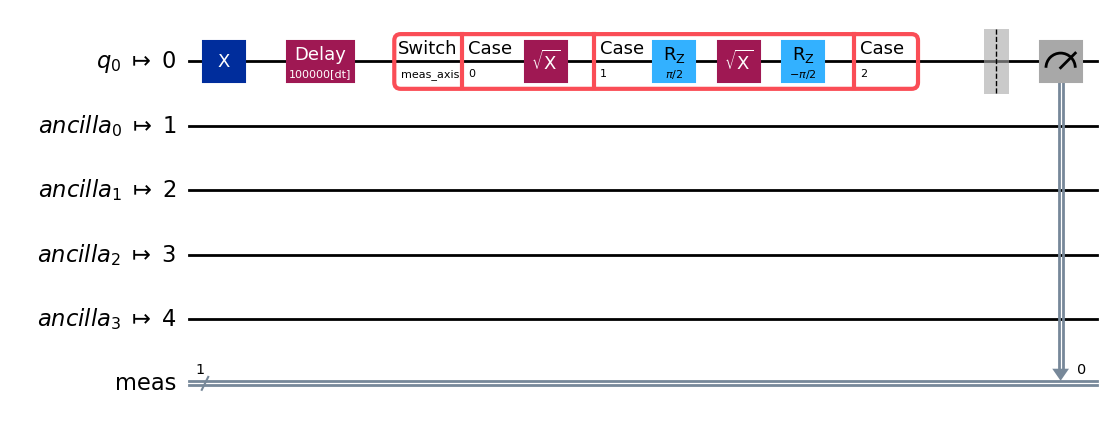

In [12]:
from qiskit import transpile

qc = transpile(cs_circuit, backend=backend, optimization_level=1)
qc.draw("mpl")

In [13]:
from qiskit.qasm3 import Exporter
exporter = Exporter(includes=(), disable_constants=True)
print(exporter.dumps(qc))

OPENQASM 3.0;
input uint[3] meas_axis;
input bool meas_axis2;
gate u3(p0, p1, p2) _gate_q_0 {
  U(p0, p1, p2) _gate_q_0;
}
gate x _gate_q_0 {
  u3(3.141592653589793, 0, 3.141592653589793) _gate_q_0;
}
gate u1(p0) _gate_q_0 {
  u3(0, 0, p0) _gate_q_0;
}
gate sdg _gate_q_0 {
  u1(-1.5707963267948966) _gate_q_0;
}
gate u2(p0, p1) _gate_q_0 {
  u3(1.5707963267948966, p0, p1) _gate_q_0;
}
gate h _gate_q_0 {
  u2(0, 3.141592653589793) _gate_q_0;
}
gate sx _gate_q_0 {
  sdg _gate_q_0;
  h _gate_q_0;
  sdg _gate_q_0;
}
gate rz(p0) _gate_q_0 {
  u1(p0) _gate_q_0;
}
bit[1] meas;
int switch_dummy;
meas_axis2 = !bool(meas_axis);
x $0;
delay[100000dt] $0;
switch_dummy = meas_axis;
switch (switch_dummy) {
  case 0 {
    sx $0;
  }
  case 1 {
    rz(1.5707963267948966) $0;
    sx $0;
    rz(-1.570796326794897) $0;
  }
  case 2 {
  }
}
barrier $0;
meas[0] = measure $0;



In [15]:
prog = backend.quantum_circuit_to_qua(qc).result_program
print(generate_qua_script(prog.dsl_program))


# Single QUA script generated at 2025-05-13 10:50:43.714311
# QUA library version: 1.2.2rc2+dgx2


from qm import CompilerOptionArguments
from qm.qua import *

with program() as prog:
    input_stream_meas_axis = declare_input_stream(int, 'meas_axis', value=0)
    input_stream_meas_axis2 = declare_input_stream(bool, 'meas_axis2', value=False)
    a1 = declare(bool, value=[False])
    v1 = declare(int, value=0)
    v2 = declare(int, )
    v3 = declare(fixed, )
    v4 = declare(fixed, )
    advance_input_stream(input_stream_meas_axis)
    advance_input_stream(input_stream_meas_axis2)
    assign(input_stream_meas_axis2, (Cast.to_bool(input_stream_meas_axis)^True))
    align("q1.resonator", "q1.xy", "q1.z")
    play("x180_DragCosine", "q1.xy")
    align("q1.resonator", "q1.xy", "q1.z")
    align("q1.resonator", "q1.xy", "q1.z")
    wait(25000, "q1.xy", "q1.resonator", "q1.z")
    align("q1.resonator", "q1.xy", "q1.z")
    assign(v1, input_stream_meas_axis)
    with if_((v1==0), unsafe=Tru

In [106]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.primitives import StatevectorSampler
from qiskit.providers.basic_provider import BasicSimulator
from qiskit_ibm_runtime.fake_provider import FakeJakartaV2
from qiskit import transpile
qreg = QuantumRegister(2, "q")
c1 = ClassicalRegister(2, "c1")
c2 = ClassicalRegister(1, "c2")
qc = QuantumCircuit(qreg, c1, c2)
qc.x(0)
qc.x(1)
qc.measure(0, c1[0])
qc.measure(0, c1[1])
qc.measure(1, c2[0])

sampler = StatevectorSampler()
job = sampler.run([(qc,)], shots=1000)
result = job.result()
fake_backend = FakeJakartaV2()
transpiled_circuit = transpile(qc, backend=fake_backend)
result2 = FakeJakartaV2().run([transpiled_circuit, transpiled_circuit], shots=1000).result()

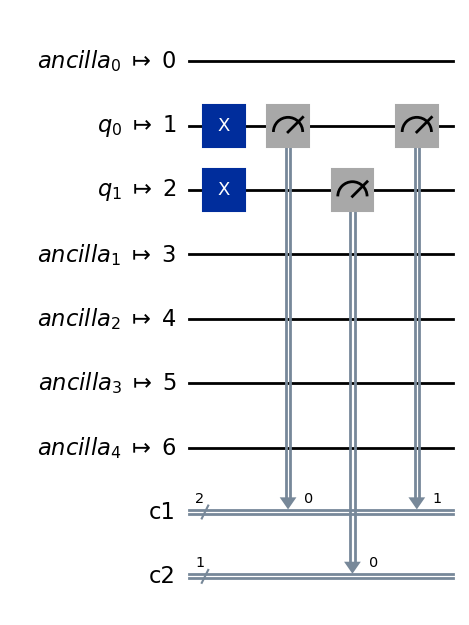

In [107]:
transpiled_circuit.draw("mpl")

In [115]:
result[0].data.c1.get_counts()

{'11': 1000}

In [111]:
result2.get_counts()

[{'0 01': 1, '0 11': 16, '1 10': 20, '1 01': 28, '1 11': 935},
 {'1 10': 23, '1 01': 16, '0 11': 18, '1 11': 943}]

In [116]:
result2

Result(backend_name='aer_simulator', backend_version='0.17.0', qobj_id='', job_id='8d7895d3-9053-4a79-a758-99d1d1ab6e89', success=True, results=[ExperimentResult(shots=1000, success=True, meas_level=2, data=ExperimentResultData(counts={'0x1': 1, '0x3': 16, '0x6': 20, '0x5': 28, '0x7': 935}), header=QobjExperimentHeader(creg_sizes=[['c1', 2], ['c2', 1]], global_phase=0.0, memory_slots=3, n_qubits=7, name='circuit-2763', qreg_sizes=[['q', 7]], metadata={}), status=DONE, seed_simulator=3045177010, metadata={'num_bind_params': 1, 'runtime_parameter_bind': False, 'parallel_state_update': 12, 'parallel_shots': 1, 'sample_measure_time': 9.5791e-05, 'noise': 'superop', 'batched_shots_optimization': False, 'remapped_qubits': True, 'active_input_qubits': [1, 2], 'device': 'CPU', 'time_taken': 0.00073275, 'measure_sampling': True, 'num_clbits': 3, 'max_memory_mb': 18432, 'input_qubit_map': [[2, 1], [1, 0]], 'num_qubits': 2, 'method': 'density_matrix', 'required_memory_mb': 1, 'fusion': {'enabled'

In [38]:
qc.find_bit(qc.clbits[0])

BitLocations(index=0, registers=[(ClassicalRegister(3, 'c1'), 0)])

In [48]:
from qiskit.circuit import ClassicalRegister, Clbit, QuantumRegister
qreg = QuantumRegister(2,"q")
clbit = Clbit()
clbit2 = Clbit()
qc = QuantumCircuit(qreg, [clbit, clbit2])
qc.x(0)
qc.measure(0, clbit)
qc.measure(1, clbit2)
qc.clbits

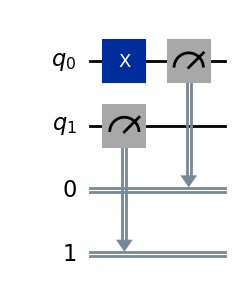

In [49]:
qc.draw("mpl")

In [53]:
print(exporter.dumps(qc))

OPENQASM 3.0;
gate u3(p0, p1, p2) _gate_q_0 {
  U(p0, p1, p2) _gate_q_0;
}
gate x _gate_q_0 {
  u3(3.141592653589793, 0, 3.141592653589793) _gate_q_0;
}
bit[3] c1;
bit[3] c2;
qubit[2] q;
x q[0];
x q[1];
c1[0] = measure q[0];
c1[1] = measure q[0];
c2[0] = measure q[1];



In [5]:
from pathlib import Path
import json
from qiskit_qm_provider import ParameterPool

path = Path.home() / "qm_saas_config.json"
with open(path, "r") as f:
    config = json.load(f)
email = config["email"]
password = config["password"]
# Initialize QOP simulator client
client = QmSaas(email=email, password=password, host="qm-saas.dev.quantum-machines.co")

# Choose your QOP version (QOP2.x.y or QOP3.x.y)
version = QoPVersion.latest
client.close_all()

In [6]:
from qm import SimulationConfig, LoopbackInterface
config = machine.generate_config()
instance = client.simulator(version=version)
instance.spawn()
# Initialize QuantumMachinesManager with the simulation instance details
qmm = QuantumMachinesManager(
    host=instance.host,
    port=instance.port,
    connection_headers=instance.default_connection_headers,
)
simulation_config = SimulationConfig(int(10000), include_analog_waveforms=True)
backend.qmm = qmm
backend.set_options(simulate=simulation_config)


2025-05-15 15:05:08,637 - qm - INFO     - Performing health check
2025-05-15 15:05:08 INFO Performing health check
2025-05-15 15:05:08,958 - qm - INFO     - Cluster healthcheck completed successfully.
2025-05-15 15:05:08 INFO Cluster healthcheck completed successfully.


In [7]:
backend._qmm

In [2]:

qc = QuantumCircuit(2)
qc.x(0)
qc.cz(0, 1)

qc.measure_all()
qc = transpile(qc, backend=backend, optimization_level=0)

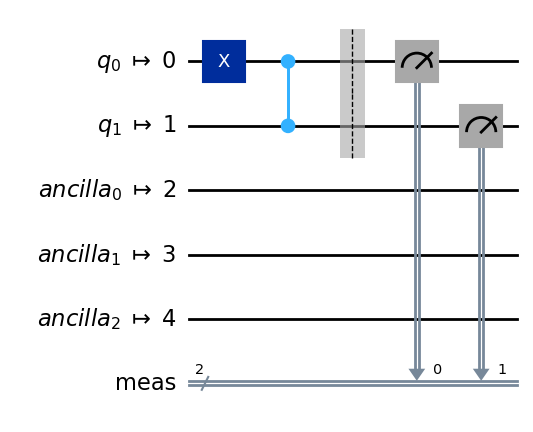

In [3]:
qc.draw("mpl")

In [9]:
from qiskit.qasm3 import Exporter

exporter = Exporter(includes=(), disable_constants=True)

print(exporter.dumps(qc))

OPENQASM 3.0;
gate u3(p0, p1, p2) _gate_q_0 {
  U(p0, p1, p2) _gate_q_0;
}
gate x _gate_q_0 {
  u3(3.141592653589793, 0, 3.141592653589793) _gate_q_0;
}
gate u2(p0, p1) _gate_q_0 {
  u3(1.5707963267948966, p0, p1) _gate_q_0;
}
gate h _gate_q_0 {
  u2(0, 3.141592653589793) _gate_q_0;
}
gate cx c, t {
  ctrl @ U(pi, 0, pi) c, t;
}
gate cz _gate_q_0, _gate_q_1 {
  h _gate_q_1;
  cx _gate_q_0, _gate_q_1;
  h _gate_q_1;
}
bit[2] meas;
x $0;
cz $0, $1;
barrier $0, $1;
meas[0] = measure $0;
meas[1] = measure $1;



In [8]:
backend.run(qc, shots=1000).result()

/Users/arthurostrauss/anaconda3/envs/rl_qoc/lib/python3.11/site-packages/qm/program/_qua_config_schema.py:1956: DeprecationWarning: 'version' is deprecated since "1.2.2" and will be removed in "1.3.0". Please remove it from the Qua config.
  warnings.warn(


2025-05-15 15:05:35,318 - qm - INFO     - Simulating program.
2025-05-15 15:05:35 INFO Simulating program.


QMConnectionError: Encountered connection error from QOP: details: Internal Server Error, status: Status.UNKNOWN

In [10]:
print(generate_qua_script(backend.get_run_program(1000, [qc])))


# Single QUA script generated at 2025-05-14 08:50:34.525250
# QUA library version: 1.2.2rc2+dgx2


from qm import CompilerOptionArguments
from qm.qua import *

with program() as prog:
    v1 = declare(int, )
    v2 = declare(int, value=0)
    a1 = declare(bool, value=[False, False])
    v3 = declare(bool, )
    v4 = declare(fixed, )
    v5 = declare(fixed, )
    v6 = declare(bool, )
    v7 = declare(fixed, )
    v8 = declare(fixed, )
    set_dc_offset("q1.z", "single", 0.0)
    set_dc_offset("q2.z", "single", 0.0)
    set_dc_offset("q3.z", "single", 0.0)
    set_dc_offset("q4.z", "single", 0.0)
    set_dc_offset("q5.z", "single", 0.0)
    set_dc_offset("coupler_q1_q2", "single", -0.01)
    set_dc_offset("coupler_q2_q3", "single", -0.03)
    set_dc_offset("coupler_q3_q4", "single", -0.053)
    set_dc_offset("coupler_q4_q5", "single", -0.051)
    with for_(v1,0,(v1<1000),(v1+1)):
        align("q1.resonator", "q1.xy", "q1.z")
        play("x180_DragCosine", "q1.xy")
        align("q1.re